# Proyek Analisis Data: [Input Nama Dataset]
- **Nama:** Mazka Buana Hidayat
- **Email:** hmazka19@gmail.com
- **ID Dicoding:** mazkaabh

## Menentukan Pertanyaan Bisnis

- Bagaimana tren polutan udara (PM2.5, PM10, dll.) berubah dari tahun ke tahun, dan stasiun mana yang menunjukkan peningkatan paling signifikan?
- Stasiun mana yang secara konsisten memiliki tingkat polutan tertinggi, dan faktor lingkungan apa (suhu, angin, hujan) yang paling berkontribusi terhadap kondisi tersebut?
- Di wilayah mana saja terdapat konsentrasi polutan (misalnya PM2.5) yang tinggi, dan bagaimana sebaran kualitas udara antar stasiun di wilayah tersebut

# Import Semua Packages/Library yang Digunakan

In [2]:
!pip install missingno -q


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\pcace\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [37]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno
from statsmodels.tsa.seasonal import seasonal_decompose
import calendar
import warnings

from scipy.stats import linregress
import folium
from folium.plugins import Fullscreen, MeasureControl, MiniMap, HeatMap
import geopandas as gpd
warnings.filterwarnings('ignore')

# Data Wrangling

## Gathering Data

In [4]:
# Tentukan path direktori
directory = r"E:\Studi Independen\Project 1\submission\data"

In [5]:
# Daftar kolom yang ingin diperiksa
columns_to_check = ['year', 'month', 'day', 'hour']

# Dictionary untuk menyimpan DataFrame dan nilai unik
dataframes = {}
unique_values = {col: set() for col in columns_to_check}

# Baca setiap file dan periksa kolom
print("Pemeriksaan kolom di setiap file:")
print("-" * 50)
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dataframes[filename] = df
        
        # Cek keberadaan kolom
        print(f"\nFile: {filename}")
        for col in columns_to_check:
            if col in df.columns:
                print(f"- {col}: Ada")
                # Simpan nilai unik untuk perbandingan
                unique_values[col].update(df[col].unique())
            else:
                print(f"- {col}: Tidak ada")

Pemeriksaan kolom di setiap file:
--------------------------------------------------

File: PRSA_Data_Aotizhongxin_20130301-20170228.csv
- year: Ada
- month: Ada
- day: Ada
- hour: Ada

File: PRSA_Data_Changping_20130301-20170228.csv
- year: Ada
- month: Ada
- day: Ada
- hour: Ada

File: PRSA_Data_Dingling_20130301-20170228.csv
- year: Ada
- month: Ada
- day: Ada
- hour: Ada

File: PRSA_Data_Dongsi_20130301-20170228.csv
- year: Ada
- month: Ada
- day: Ada
- hour: Ada

File: PRSA_Data_Guanyuan_20130301-20170228.csv
- year: Ada
- month: Ada
- day: Ada
- hour: Ada

File: PRSA_Data_Gucheng_20130301-20170228.csv
- year: Ada
- month: Ada
- day: Ada
- hour: Ada

File: PRSA_Data_Huairou_20130301-20170228.csv
- year: Ada
- month: Ada
- day: Ada
- hour: Ada

File: PRSA_Data_Nongzhanguan_20130301-20170228.csv
- year: Ada
- month: Ada
- day: Ada
- hour: Ada

File: PRSA_Data_Shunyi_20130301-20170228.csv
- year: Ada
- month: Ada
- day: Ada
- hour: Ada

File: PRSA_Data_Tiantan_20130301-20170228.csv
-

In [6]:
# Bandingkan nilai unik di semua file
print("\n" + "=" * 50)
print("Pemeriksaan kesamaan nilai di semua file:")
print("=" * 50)
for col in columns_to_check:
    if unique_values[col]:  # Jika ada nilai (kolom ditemukan)
        print(f"\nKolom: {col}")
        print(f"Jumlah nilai unik: {len(unique_values[col])}")
        print(f"Nilai unik: {sorted(unique_values[col])}")
        print(f"Kesimpulan: {'Sama untuk semua file' if len(dataframes) > 0 else 'Tidak dapat dibandingkan (hanya 1 file)'}")
    else:
        print(f"\nKolom: {col}")
        print("Tidak ditemukan di semua file")


Pemeriksaan kesamaan nilai di semua file:

Kolom: year
Jumlah nilai unik: 5
Nilai unik: [2013, 2014, 2015, 2016, 2017]
Kesimpulan: Sama untuk semua file

Kolom: month
Jumlah nilai unik: 12
Nilai unik: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Kesimpulan: Sama untuk semua file

Kolom: day
Jumlah nilai unik: 31
Nilai unik: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Kesimpulan: Sama untuk semua file

Kolom: hour
Jumlah nilai unik: 24
Nilai unik: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Kesimpulan: Sama untuk semua file


**Insight:**
- Untuk semua file stasiun memiliki 'year', 'month', 'day', 'hour' dan waktu yang sama

## Assessing Data

In [7]:
# Buat list kosong untuk menyimpan semua DataFrame
all_data = []

# Loop melalui semua file dalam direktori
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        # Baca CSV dan tambahkan ke list
        df = pd.read_csv(filepath)
        all_data.append(df)
        print(f"Berhasil membaca {filename}")

# Gabungkan semua DataFrame menjadi satu
combined_df = pd.concat(all_data, ignore_index=True)

Berhasil membaca PRSA_Data_Aotizhongxin_20130301-20170228.csv
Berhasil membaca PRSA_Data_Changping_20130301-20170228.csv
Berhasil membaca PRSA_Data_Dingling_20130301-20170228.csv
Berhasil membaca PRSA_Data_Dongsi_20130301-20170228.csv
Berhasil membaca PRSA_Data_Guanyuan_20130301-20170228.csv
Berhasil membaca PRSA_Data_Gucheng_20130301-20170228.csv
Berhasil membaca PRSA_Data_Huairou_20130301-20170228.csv
Berhasil membaca PRSA_Data_Nongzhanguan_20130301-20170228.csv
Berhasil membaca PRSA_Data_Shunyi_20130301-20170228.csv
Berhasil membaca PRSA_Data_Tiantan_20130301-20170228.csv
Berhasil membaca PRSA_Data_Wanliu_20130301-20170228.csv
Berhasil membaca PRSA_Data_Wanshouxigong_20130301-20170228.csv


In [8]:
combined_df

No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  \
0           1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0   
1           2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0   
2           3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0   
3           4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0   
4           5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0   
...       ...   ...    ...  ...   ...    ...   ...   ...   ...    ...   ...   
420763  35060  2017      2   28    19   11.0  32.0   3.0  24.0  400.0  72.0   
420764  35061  2017      2   28    20   13.0  32.0   3.0  41.0  500.0  50.0   
420765  35062  2017      2   28    21   14.0  28.0   4.0  38.0  500.0  54.0   
420766  35063  2017      2   28    22   12.0  23.0   4.0  30.0  400.0  59.0   
420767  35064  2017      2   28    23   13.0  19.0   4.0  38.0  600.0  49.0   

        TEMP    PRES  DEWP  RAIN   wd  WSPM        station  
0       -0.7  1023.0 -18.8   0.0  NNW   4.4   Aotizhongxin  
1       -1.1  1023.2 -18.2   0.0    N   4.7   Aotizhongxin  
2       -1.1  1023.5 -18.2   0.0  NNW   5.6   Aotizhongxin  
3       -1.4  1024.5 -19.4   0.0   NW   3.1   Aotizhongxin  
4       -2.0  1025.2 -19.5   0.0    N   2.0   Aotizhongxin  
...      ...     ...   ...   ...  ...   ...            ...  
420763  12.5  1013.5 -16.2   0.0   NW   2.4  Wanshouxigong  
420764  11.6  1013.6 -15.1   0.0  WNW   0.9  Wanshouxigong  
420765  10.8  1014.2 -13.3   0.0   NW   1.1  Wanshouxigong  
420766  10.5  1014.4 -12.9   0.0  NNW   1.2  Wanshouxigong  
420767   8.6  1014.1 -15.9   0.0  NNE   1.3  Wanshouxigong  

[420768 rows x 18 columns]

In [9]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB


In [10]:
combined_df['station'].unique()

array(['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 'Guanyuan',
       'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan',
       'Wanliu', 'Wanshouxigong'], dtype=object)

**Insight:**
- kita bisa menggabungkan semua file *.csv menjadi 1 dataframe combined_df agar mempermudah visualisasi

## Cleaning Data

In [11]:
combined_df['timestamp'] = pd.to_datetime(combined_df[['year', 'month', 'day', 'hour']])
combined_df = combined_df.drop(columns=['year', 'month', 'day', 'hour'])
combined_df

No  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  RAIN  \
0           1    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   0.0   
1           2    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   0.0   
2           3    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   0.0   
3           4    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   0.0   
4           5    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   0.0   
...       ...    ...   ...   ...   ...    ...   ...   ...     ...   ...   ...   
420763  35060   11.0  32.0   3.0  24.0  400.0  72.0  12.5  1013.5 -16.2   0.0   
420764  35061   13.0  32.0   3.0  41.0  500.0  50.0  11.6  1013.6 -15.1   0.0   
420765  35062   14.0  28.0   4.0  38.0  500.0  54.0  10.8  1014.2 -13.3   0.0   
420766  35063   12.0  23.0   4.0  30.0  400.0  59.0  10.5  1014.4 -12.9   0.0   
420767  35064   13.0  19.0   4.0  38.0  600.0  49.0   8.6  1014.1 -15.9   0.0   

         wd  WSPM        station           timestamp  
0       NNW   4.4   Aotizhongxin 2013-03-01 00:00:00  
1         N   4.7   Aotizhongxin 2013-03-01 01:00:00  
2       NNW   5.6   Aotizhongxin 2013-03-01 02:00:00  
3        NW   3.1   Aotizhongxin 2013-03-01 03:00:00  
4         N   2.0   Aotizhongxin 2013-03-01 04:00:00  
...     ...   ...            ...                 ...  
420763   NW   2.4  Wanshouxigong 2017-02-28 19:00:00  
420764  WNW   0.9  Wanshouxigong 2017-02-28 20:00:00  
420765   NW   1.1  Wanshouxigong 2017-02-28 21:00:00  
420766  NNW   1.2  Wanshouxigong 2017-02-28 22:00:00  
420767  NNE   1.3  Wanshouxigong 2017-02-28 23:00:00  

[420768 rows x 15 columns]

**Insight:**
- Kita bisa menggabungkan 'year', 'month', 'day', 'hour' menjadi 'timestamp' untuk analisis lebih dalam

# Exploratory Data Analysis (EDA)

### Univariate Analysis

In [41]:
# Daftar variabel numerik yang dianalisis
numeric_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

# Statistik ringkasan
print("Statistik Ringkasan Variabel Numerik:")
print(combined_df[numeric_cols].describe())

Statistik Ringkasan Variabel Numerik:
               PM2.5           PM10            SO2            NO2  \
count  412029.000000  414319.000000  411747.000000  408652.000000   
mean       79.793428     104.602618      15.830835      50.638586   
std        80.822391      91.772426      21.650603      35.127912   
min         2.000000       2.000000       0.285600       1.026500   
25%        20.000000      36.000000       3.000000      23.000000   
50%        55.000000      82.000000       7.000000      43.000000   
75%       111.000000     145.000000      20.000000      71.000000   
max       999.000000     999.000000     500.000000     290.000000   

                  CO             O3           TEMP           PRES  \
count  400067.000000  407491.000000  420370.000000  420375.000000   
mean     1230.766454      57.372271      13.538976    1010.746982   
std      1160.182716      56.661607      11.436139      10.474055   
min       100.000000       0.214200     -19.900000     982.40000

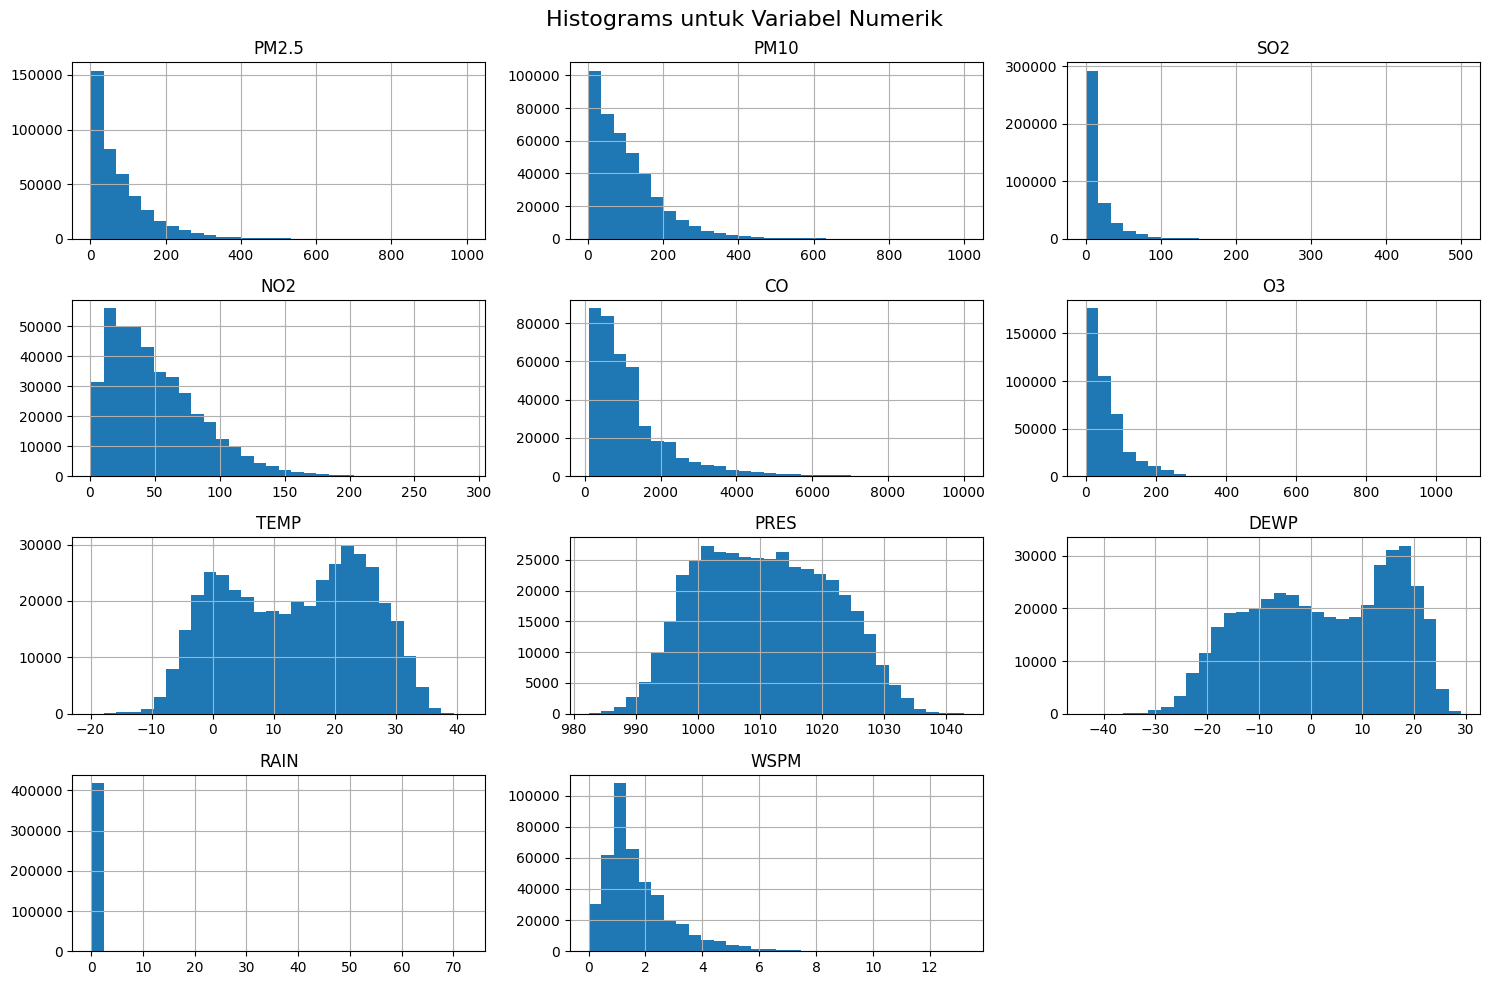

In [42]:
combined_df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms untuk Variabel Numerik", fontsize=16)
plt.tight_layout()
plt.show()

**Insight:**
- Histogram dan boxplot membantu mengidentifikasi apakah distribusi data normal, skewed, atau memiliki outlier.

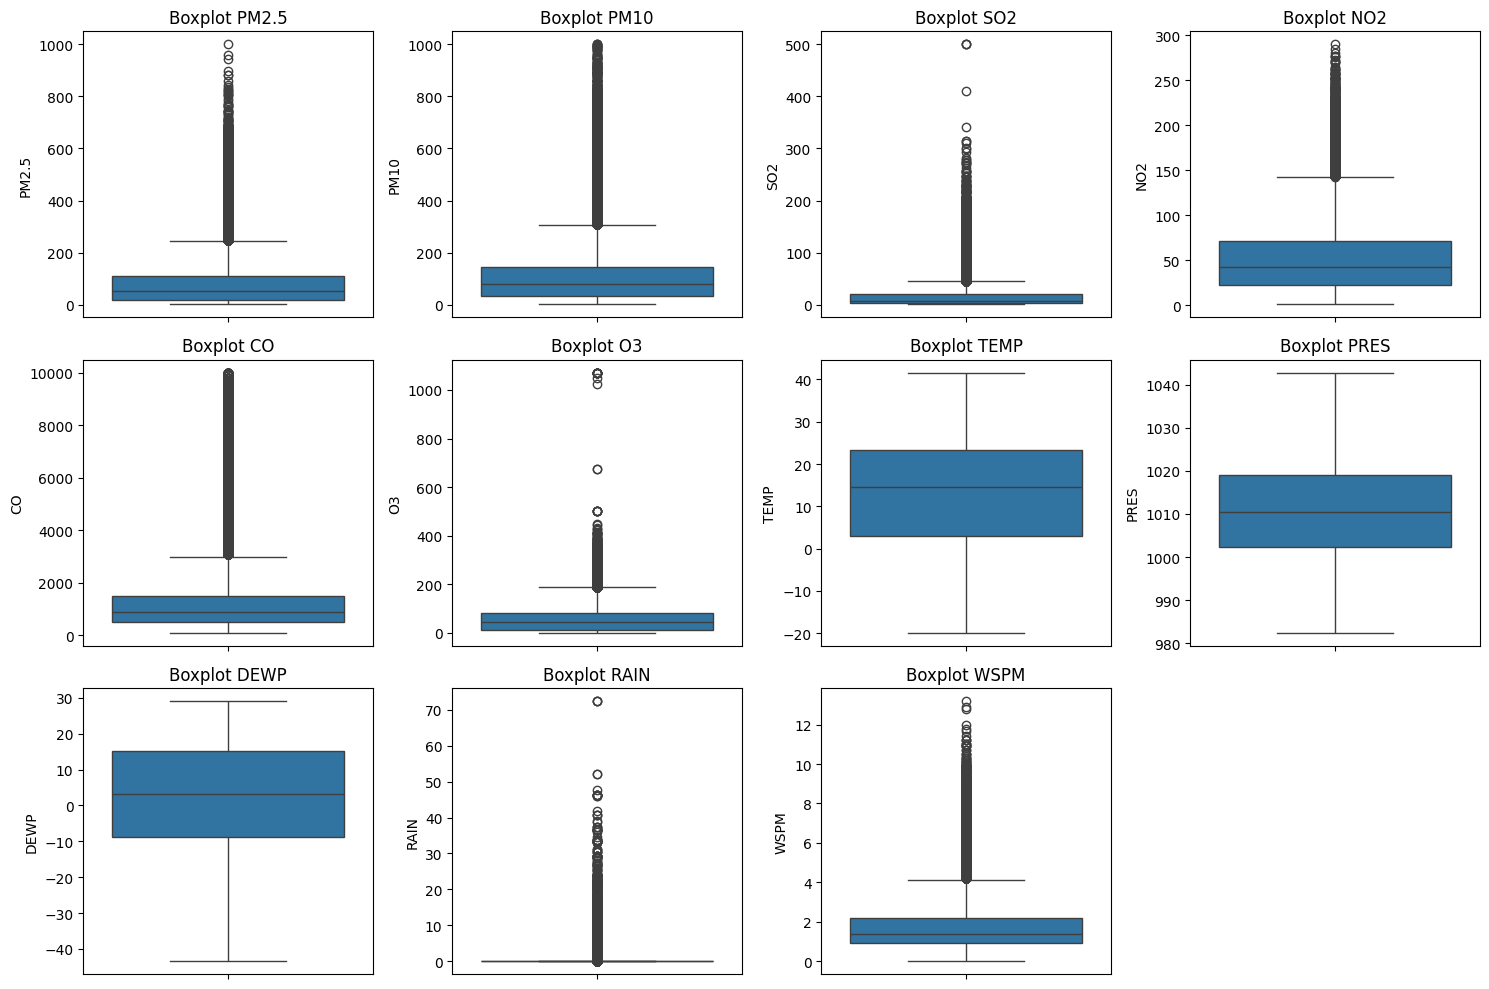

In [43]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=combined_df[col])
    plt.title(f"Boxplot {col}")
plt.tight_layout()
plt.show()

### Bivariate Analysis

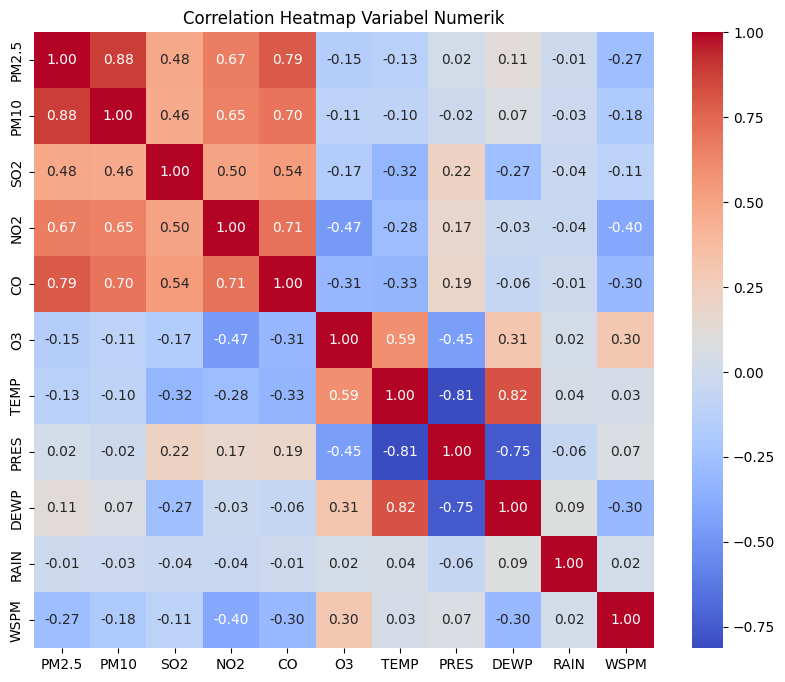

In [45]:
corr_matrix = combined_df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap Variabel Numerik")
plt.show()

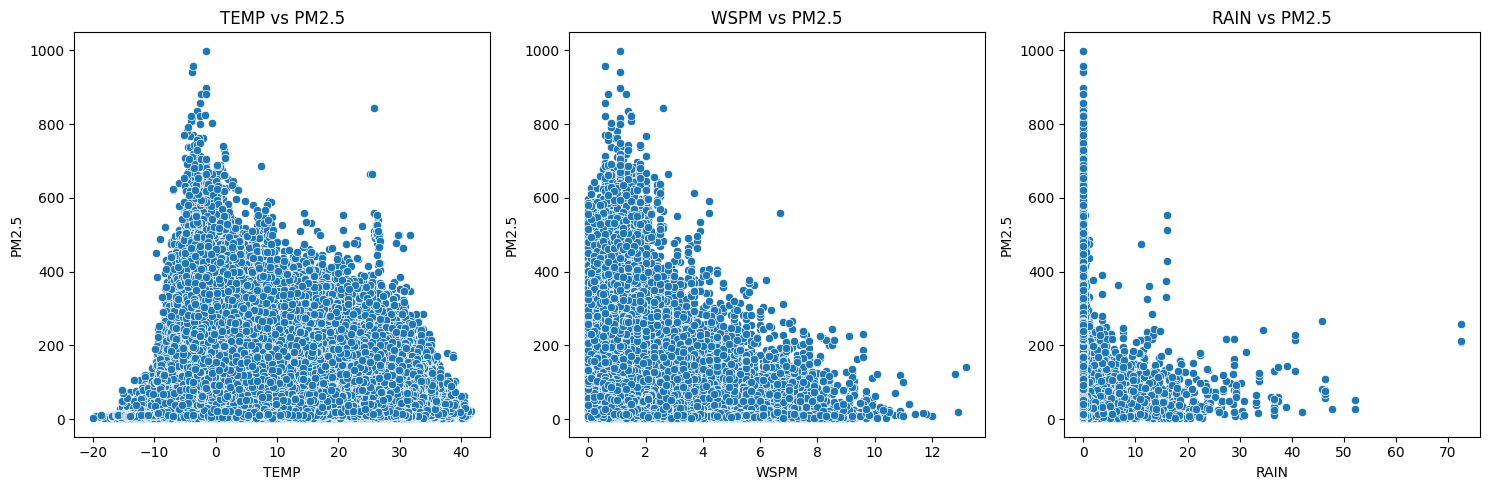

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.scatterplot(x='TEMP', y='PM2.5', data=combined_df)
plt.title("TEMP vs PM2.5")

plt.subplot(1,3,2)
sns.scatterplot(x='WSPM', y='PM2.5', data=combined_df)
plt.title("WSPM vs PM2.5")

plt.subplot(1,3,3)
sns.scatterplot(x='RAIN', y='PM2.5', data=combined_df)
plt.title("RAIN vs PM2.5")

plt.tight_layout()
plt.show()



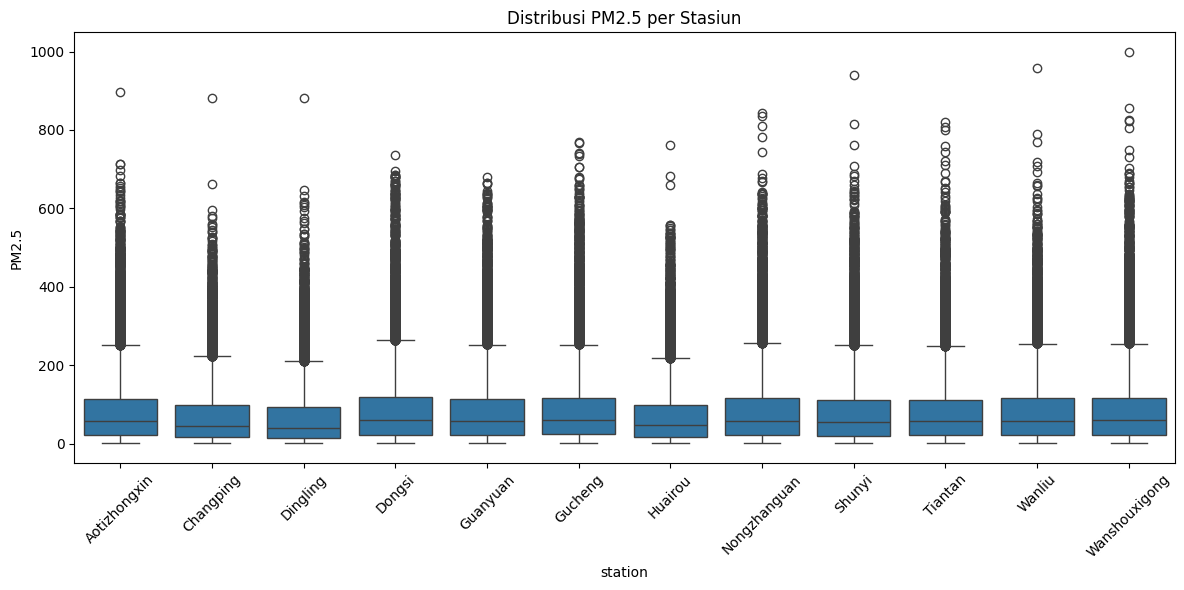

In [48]:
plt.figure(figsize=(12,6))
sns.boxplot(x='station', y='PM2.5', data=combined_df)
plt.xticks(rotation=45)
plt.title("Distribusi PM2.5 per Stasiun")
plt.tight_layout()
plt.show()

**Insight:**
- Korelasi: Heatmap menunjukkan variabel mana yang berkorelasi positif atau negatif (misalnya, apakah suhu berhubungan dengan PM2.5).
- Hubungan Variabel: Scatter plot mengungkap pola hubungan antara variabel cuaca (seperti TEMP, WSPM, RAIN) dengan PM2.5.
- Perbandingan Kategori: Boxplot per stasiun membantu mengidentifikasi apakah ada perbedaan signifikan antar lokasi dalam hal konsentrasi PM2.5.

### Multivariate Analysis

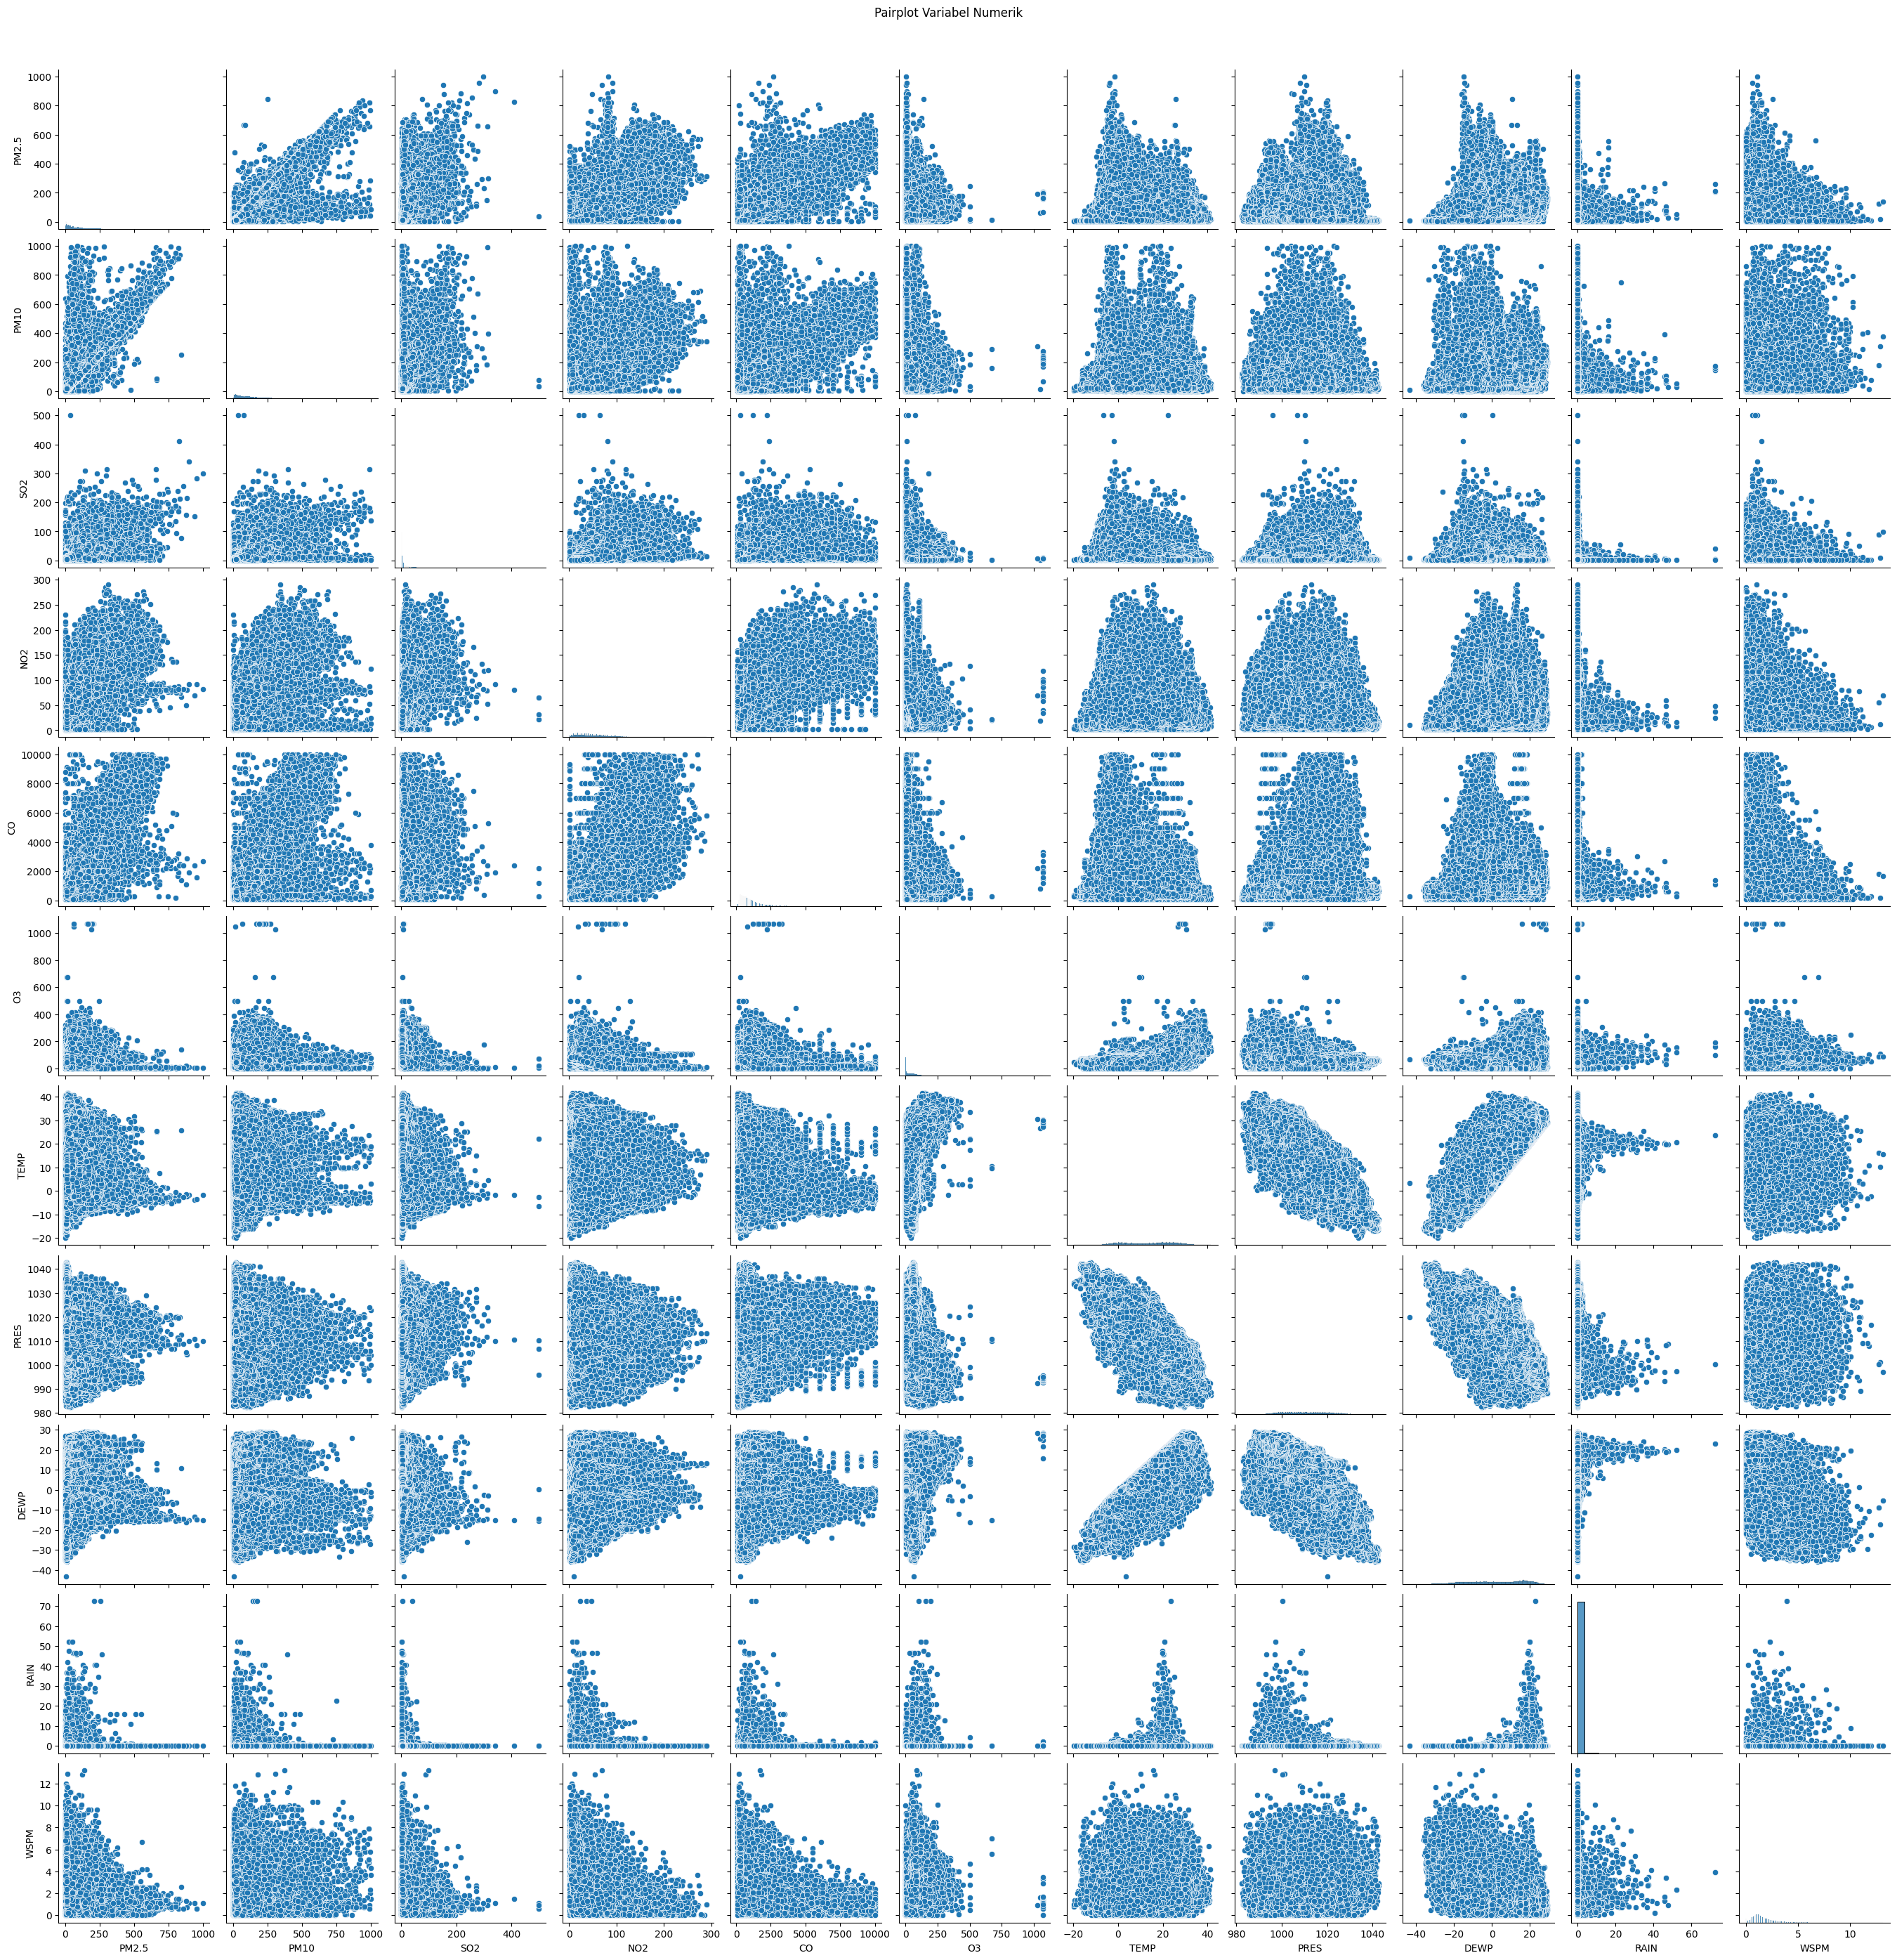

In [49]:
sns.pairplot(combined_df[numeric_cols])
plt.suptitle("Pairplot Variabel Numerik", y=1.02)
plt.show()

**Insight:**
- Pairplot membantu melihat interaksi antar banyak variabel sekaligus, sehingga pola hubungan yang mungkin tidak tampak dalam scatter plot tunggal dapat terungkap.

# Visualization & Explanatory Analysis

### Bagaimana tren polutan udara (PM2.5, PM10, dll.) berubah dari tahun ke tahun, dan stasiun mana yang menunjukkan peningkatan paling signifikan?

In [12]:
combined_df.head()

No  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  RAIN   wd  \
0   1    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   0.0  NNW   
1   2    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   0.0    N   
2   3    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   0.0  NNW   
3   4    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   0.0   NW   
4   5    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   0.0    N   

   WSPM       station           timestamp  
0   4.4  Aotizhongxin 2013-03-01 00:00:00  
1   4.7  Aotizhongxin 2013-03-01 01:00:00  
2   5.6  Aotizhongxin 2013-03-01 02:00:00  
3   3.1  Aotizhongxin 2013-03-01 03:00:00  
4   2.0  Aotizhongxin 2013-03-01 04:00:00

In [ ]:
# 1. Daftar stasiun unik
stations = combined_df['station'].unique()
print("Stasiun unik:", stations)

pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

# 2. Agregasi combined_df per tahun untuk semua stasiun
annual_avg = combined_df.groupby(combined_df['timestamp'].dt.year)[pollutants].mean().reset_index()
print("\nRata-rata tahunan tiap polutan:")
print(annual_avg)

Stasiun unik: ['Aotizhongxin' 'Changping' 'Dingling' 'Dongsi' 'Guanyuan' 'Gucheng'
 'Huairou' 'Nongzhanguan' 'Shunyi' 'Tiantan' 'Wanliu' 'Wanshouxigong']

Rata-rata tahunan tiap polutan:
   timestamp      PM2.5        PM10        SO2        NO2           CO  \
0       2013  80.040536  102.823208  20.048420  52.534040  1203.131299   
1       2014  85.575700  116.126691  20.878454  54.781129  1256.904078   
2       2015  79.626788  103.613500  13.014975  48.191862  1257.823438   
3       2016  71.930151   94.615609   9.799084  46.395580  1138.790118   
4       2017  92.675992  111.117149  18.136980  57.331760  1599.710005   

          O3  
0  57.326222  
1  58.307991  
2  59.240321  
3  57.455946  
4  39.914663  


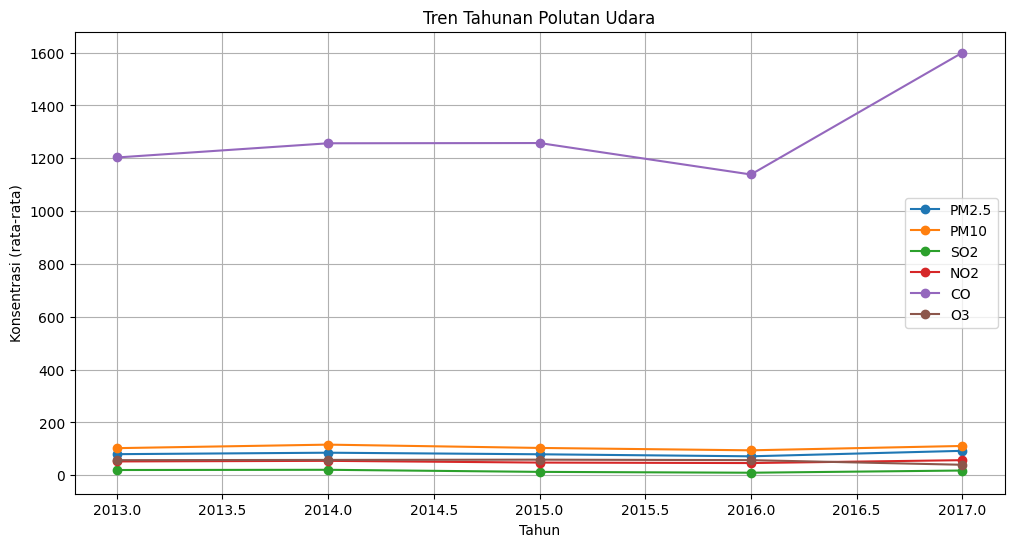

In [16]:
# 3. Visualisasi tren tahunan polutan
plt.figure(figsize=(12, 6))
for pollutant in pollutants:
    plt.plot(annual_avg['timestamp'], annual_avg[pollutant], marker='o', label=pollutant)
plt.xlabel('Tahun')
plt.ylabel('Konsentrasi (rata-rata)')
plt.title('Tren Tahunan Polutan Udara')
plt.legend()
plt.grid(True)
plt.show()

**Insight:**
- Lonjakan CO di 2017 mungkin berkaitan dengan intensitas aktivitas pembakaran (misalnya dari sektor transportasi atau industri) yang meningkat secara signifikan pada tahun tersebut.
- Polutan lainnya terlihat konstan tidak banyak perubahan


Slope tren tiap stasiun (unit per tahun):
                  PM2.5      PM10       SO2       NO2          CO        O3
Aotizhongxin   0.804761 -3.858098 -1.597815 -0.984160  100.792962  0.806043
Changping     -0.284132 -1.403059 -1.860764  1.958979   91.174435 -6.602541
Dingling      -0.710725 -1.015945 -0.899651  0.686738   62.445432 -2.790123
Dongsi         2.587000  3.972807 -1.954750 -0.408139   35.797678 -4.932300
Guanyuan       1.063563  0.766662 -1.261368  0.338565   44.737030 -2.580574
Gucheng        2.698216  0.506604 -0.360903 -0.982121   74.479775 -5.388046
Huairou       -0.499952 -2.347350 -2.528647 -0.471713   49.056821 -4.318346
Nongzhanguan   2.040474  0.341720 -1.814113 -1.217800   67.765662 -3.892642
Shunyi         2.397386  0.164151  0.311997  2.522929   95.976718 -3.137528
Tiantan        1.761618  1.676130 -1.902692  1.569503   69.921668 -3.914429
Wanliu        -1.286566 -4.015912 -2.115179 -1.583117   84.593993 -1.539927
Wanshouxigong  3.602223 -0.412667 -1.791421  

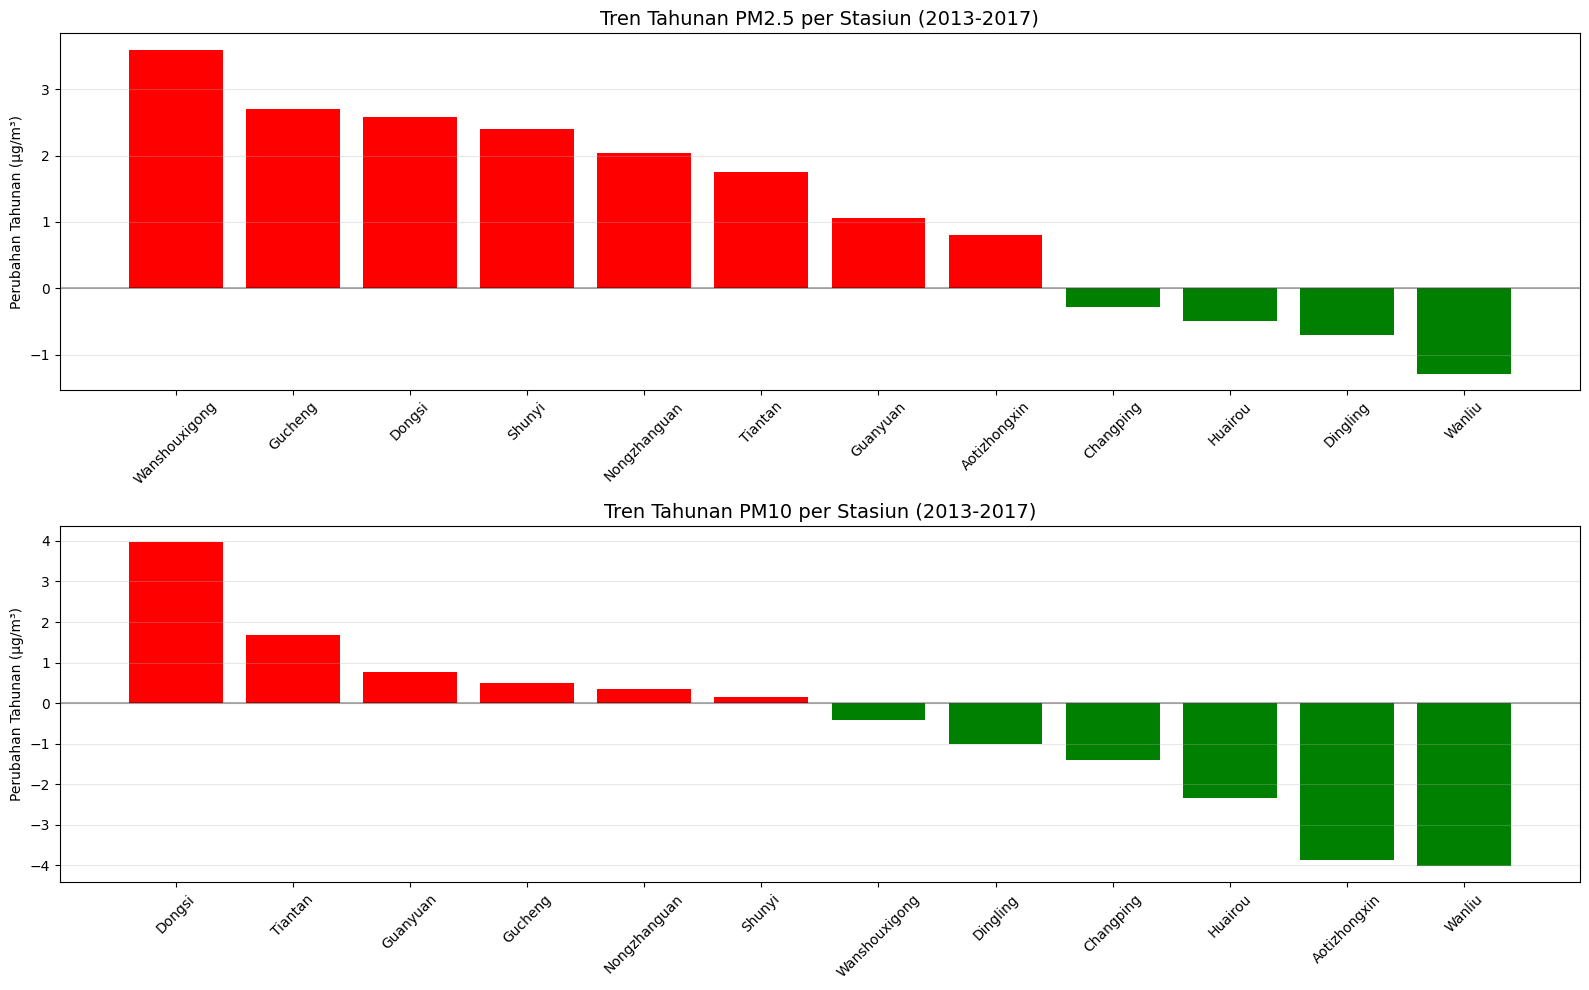

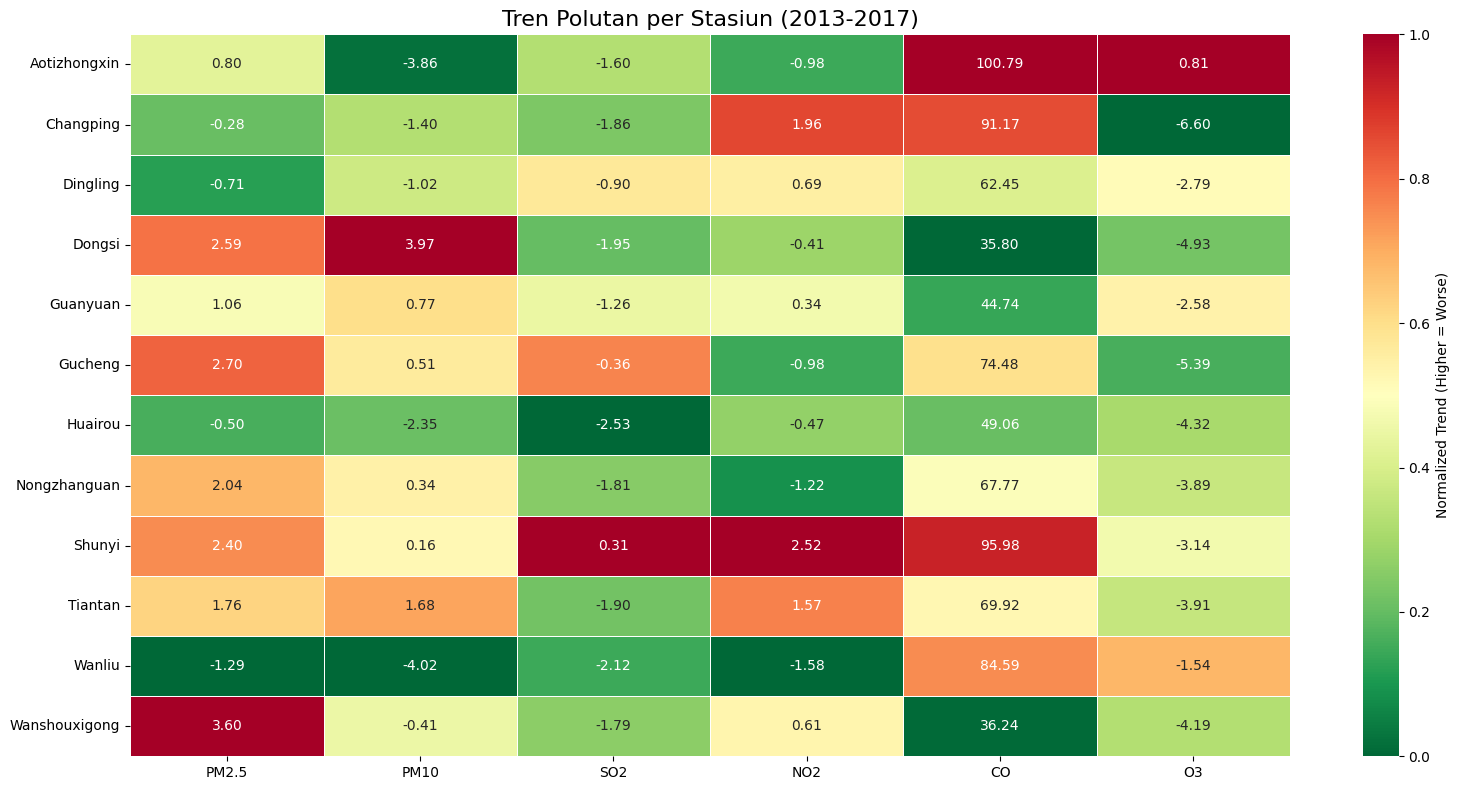

In [ ]:
# 4. Analisis tren per stasiun: menghitung slope tren tiap polutan per stasiun
station_trends = {}
for station in stations:
    station_data = combined_df[combined_df['station'] == station]
    station_data['year'] = station_data['timestamp'].dt.year  
    annual_station = station_data.groupby('year')[pollutants].mean().reset_index()
    slopes = {}
    for pollutant in pollutants:
        if len(annual_station) >= 2:
            slope, intercept, r_value, p_value, std_err = linregress(annual_station['year'], annual_station[pollutant])
            slopes[pollutant] = slope
        else:
            slopes[pollutant] = np.nan
    station_trends[station] = slopes

station_trends_df = pd.DataFrame(station_trends).T
print("\nSlope tren tiap stasiun (unit per tahun):")
print(station_trends_df)

# Menentukan stasiun dengan peningkatan paling signifikan untuk tiap polutan
max_increase_stations = {}
for pollutant in pollutants:
    station_with_max = station_trends_df[pollutant].idxmax()  
    max_increase_stations[pollutant] = station_with_max

print("\nStasiun dengan peningkatan paling signifikan per polutan:")
for pollutant, station in max_increase_stations.items():
    print(f"{pollutant}: {station}")

plt.figure(figsize=(16, 10))

# Visualisasi untuk PM2.5
plt.subplot(2, 1, 1)
stations_sorted = station_trends_df['PM2.5'].sort_values(ascending=False).index
values = station_trends_df.loc[stations_sorted, 'PM2.5']
colors = ['green' if x < 0 else 'red' for x in values]
plt.bar(stations_sorted, values, color=colors)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Tren Tahunan PM2.5 per Stasiun (2013-2017)', fontsize=14)
plt.ylabel('Perubahan Tahunan (μg/m³)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Visualisasi untuk PM10
plt.subplot(2, 1, 2)
stations_sorted = station_trends_df['PM10'].sort_values(ascending=False).index
values = station_trends_df.loc[stations_sorted, 'PM10']
colors = ['green' if x < 0 else 'red' for x in values]
plt.bar(stations_sorted, values, color=colors)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Tren Tahunan PM10 per Stasiun (2013-2017)', fontsize=14)
plt.ylabel('Perubahan Tahunan (μg/m³)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Visualisasi heatmap untuk semua polutan
plt.figure(figsize=(16, 8))
normalized_df = station_trends_df.copy()
for col in normalized_df.columns:
    normalized_df[col] = (normalized_df[col] - normalized_df[col].min()) / (normalized_df[col].max() - normalized_df[col].min())

# Membuat heatmap untuk tren polutan
sns.heatmap(normalized_df, cmap='RdYlGn_r', annot=station_trends_df.round(2), fmt='.2f',
            linewidths=0.5, cbar_kws={'label': 'Normalized Trend (Higher = Worse)'})
plt.title('Tren Polutan per Stasiun (2013-2017)', fontsize=16)
plt.tight_layout()
plt.show()

**Insight:**
- Peningkatan PM2.5 yang cepat dapat berdampak serius pada kesehatan masyarakat. Perlu investigasi lebih lanjut terkait sumber emisi lokal dan upaya mitigasi di area ini.
- Perbedaan tren antar stasiun mengindikasikan bahwa faktor lokal (seperti sumber emisi spesifik, kepadatan lalu lintas, dan aktivitas industri) sangat menentukan kondisi kualitas udara. Misalnya, Wanshouxigong dan Dongsi perlu mendapatkan perhatian khusus terkait peningkatan partikel udara, sedangkan Shunyi harus fokus pada pengendalian emisi gas SO2 dan NO2.

### Stasiun mana yang secara konsisten memiliki tingkat polutan tertinggi, dan faktor lingkungan apa (suhu, angin, hujan) yang paling berkontribusi terhadap kondisi tersebut?

<Figure size 1200x800 with 0 Axes>

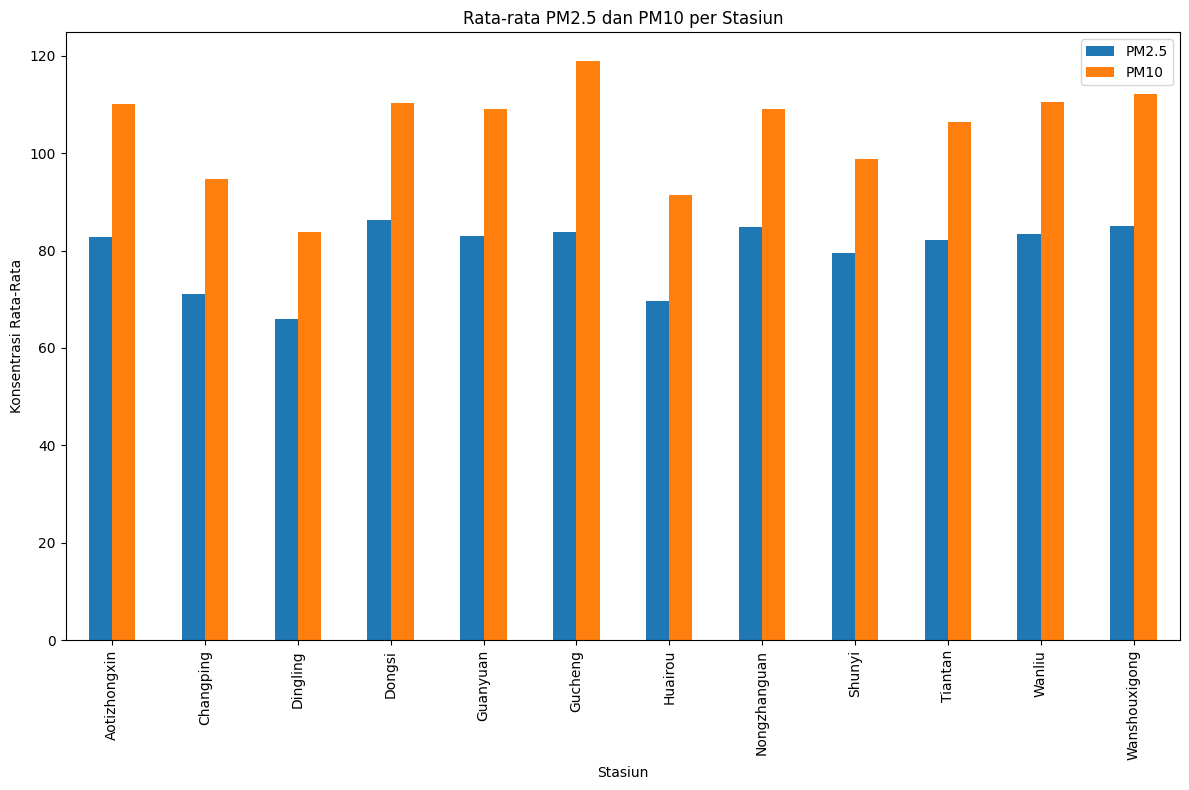

In [ ]:
# Daftar polutan dan variabel cuaca yang akan dianalisis
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
weather_vars = ['TEMP', 'WSPM', 'PRES', 'DEWP'] 

# ------------------------------
# 1. Bar Chart: Rata-rata PM2.5 dan PM10 per Stasiun
# ------------------------------
station_means = combined_df.groupby('station')[pollutants].mean()
plt.figure(figsize=(12,8))
station_means[['PM2.5', 'PM10']].plot(kind='bar', figsize=(12,8))
plt.title('Rata-rata PM2.5 dan PM10 per Stasiun')
plt.xlabel('Stasiun')
plt.ylabel('Konsentrasi Rata-Rata')
plt.legend()
plt.tight_layout()
plt.show()

**Insight:**
- Polutan pm10 di setiap stasiun memiliki rata rata lebih tinggi dibandingkan pm2.5

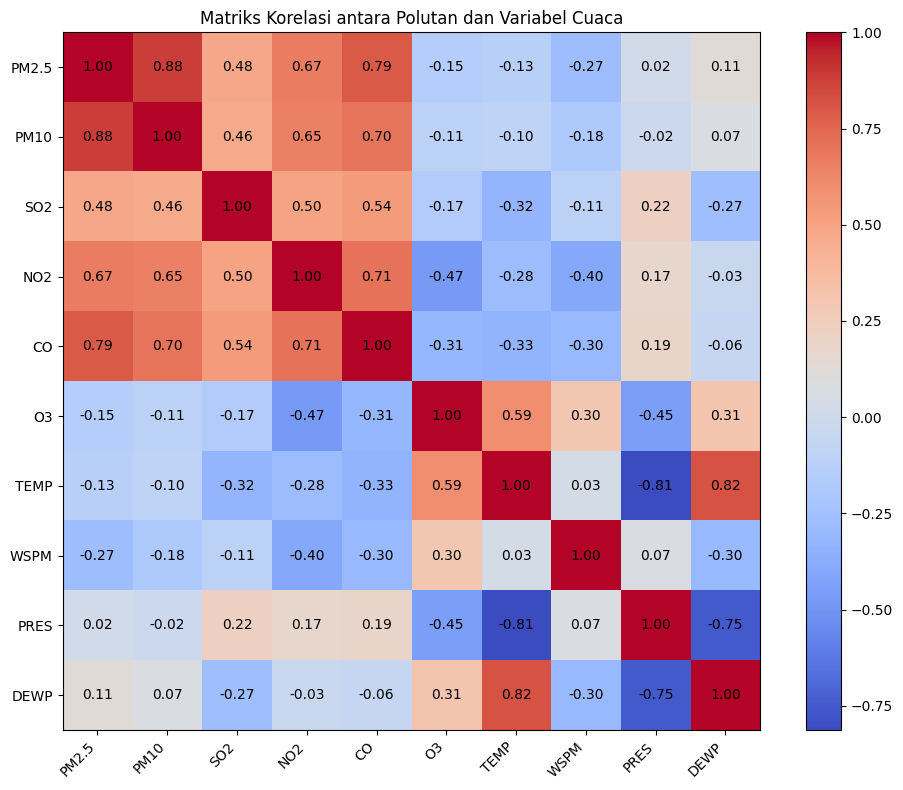

In [ ]:
cols_to_use = pollutants + weather_vars
corr_matrix = combined_df[cols_to_use].corr()

plt.figure(figsize=(10,8))
im = plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(im)
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45, ha="right")
plt.yticks(range(len(corr_matrix)), corr_matrix.index)
plt.title("Matriks Korelasi antara Polutan dan Variabel Cuaca")
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black")
plt.tight_layout()
plt.show()

**Insight:**
- Korelasi polutan NO2 dengan WSPM (Wind Speed) memiliki korelasi negatif terbesar diantara variabel polutan dengan variabel cuaca lainnya

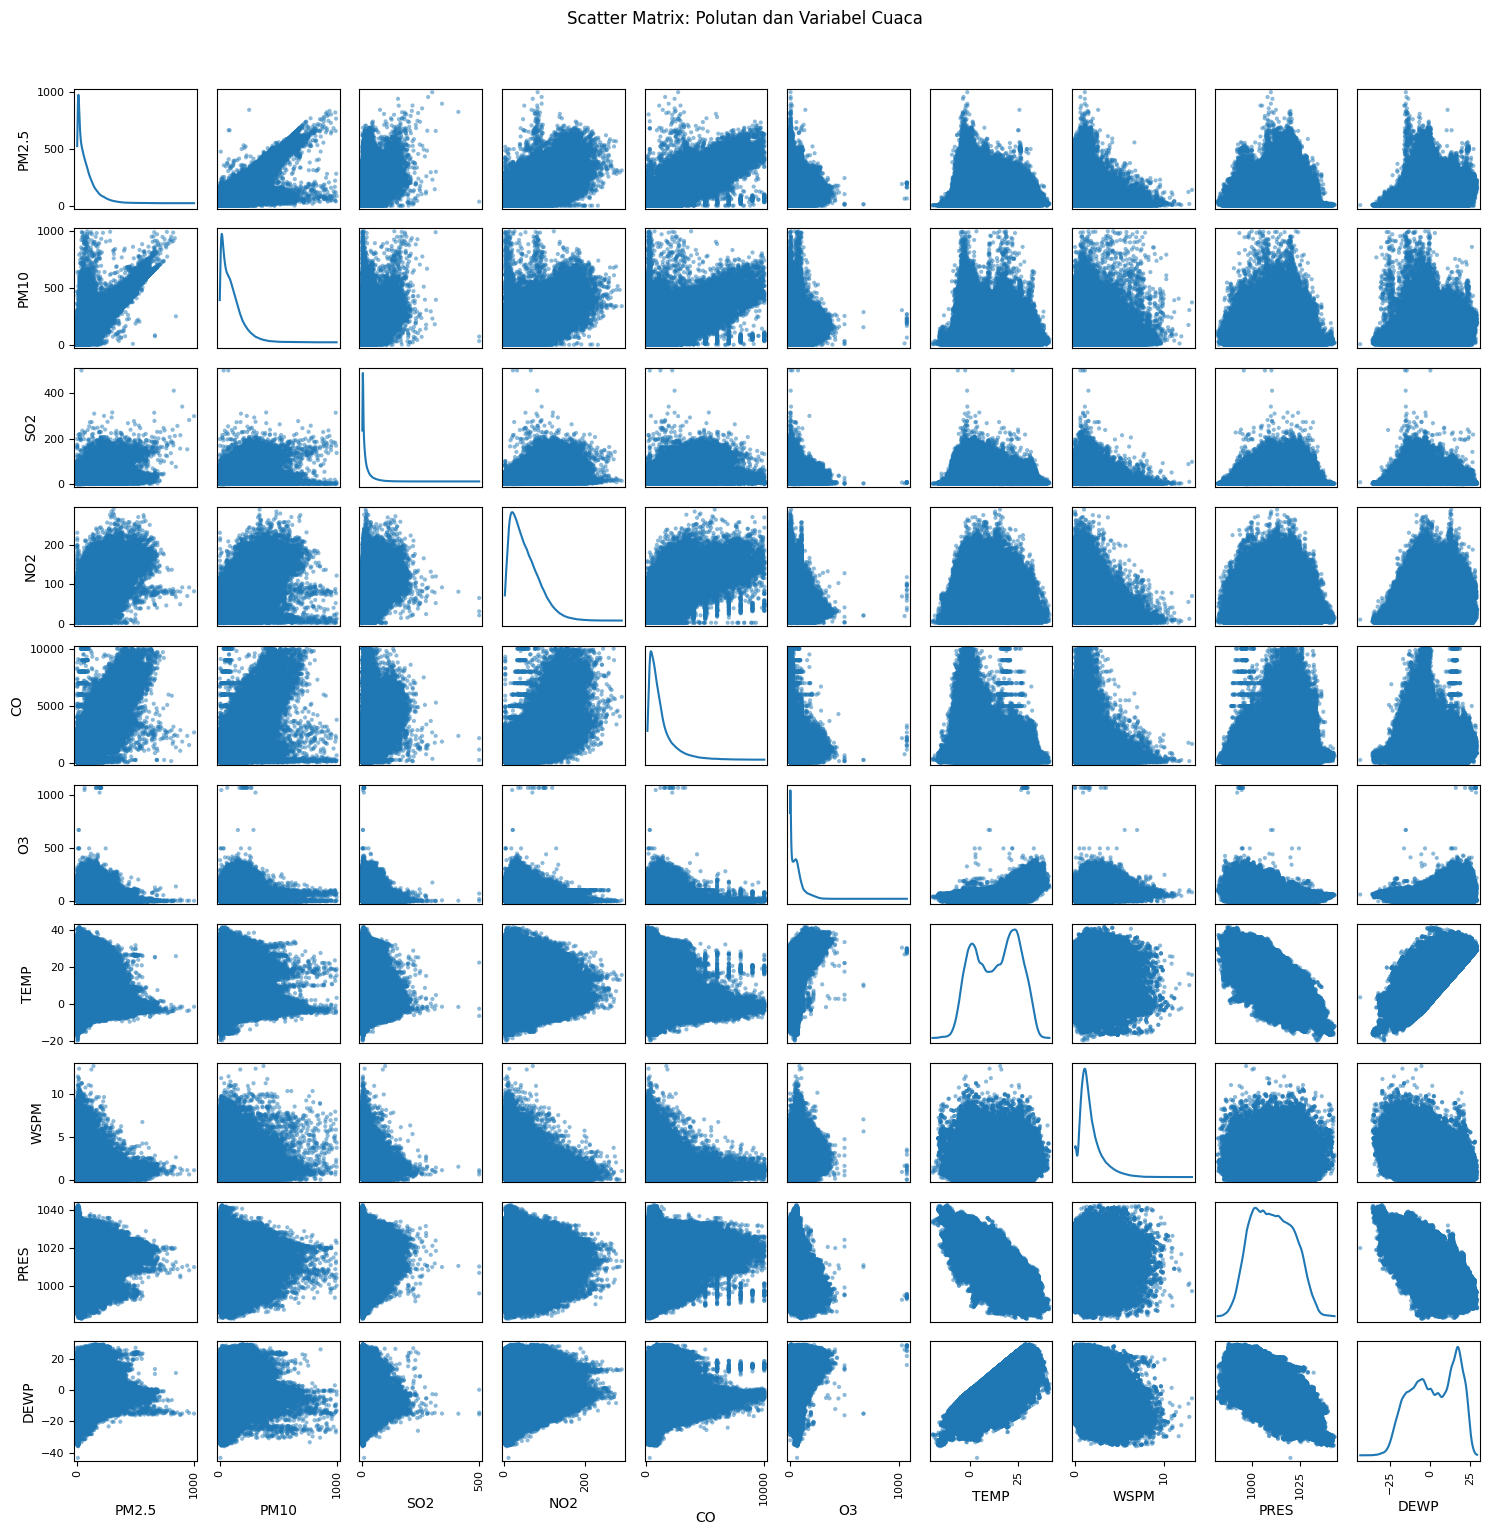

In [30]:
pd.plotting.scatter_matrix(combined_df[cols_to_use], figsize=(15,15), diagonal='kde', alpha=0.5)
plt.suptitle("Scatter Matrix: Polutan dan Variabel Cuaca", y=1.02)
plt.tight_layout()
plt.show()

**Insight:**
- Beberapa plot sebaran menunjukkan hubungan non-linear, yang menunjukkan interaksi yang lebih kompleks.

- Pencilan di beberapa plot dapat mengindikasikan kejadian yang tidak biasa atau anomali data.

- Histogram di sepanjang diagonal menunjukkan distribusi setiap variabel.

Stasiun dengan tingkat polutan tertinggi secara konsisten: Nongzhanguan


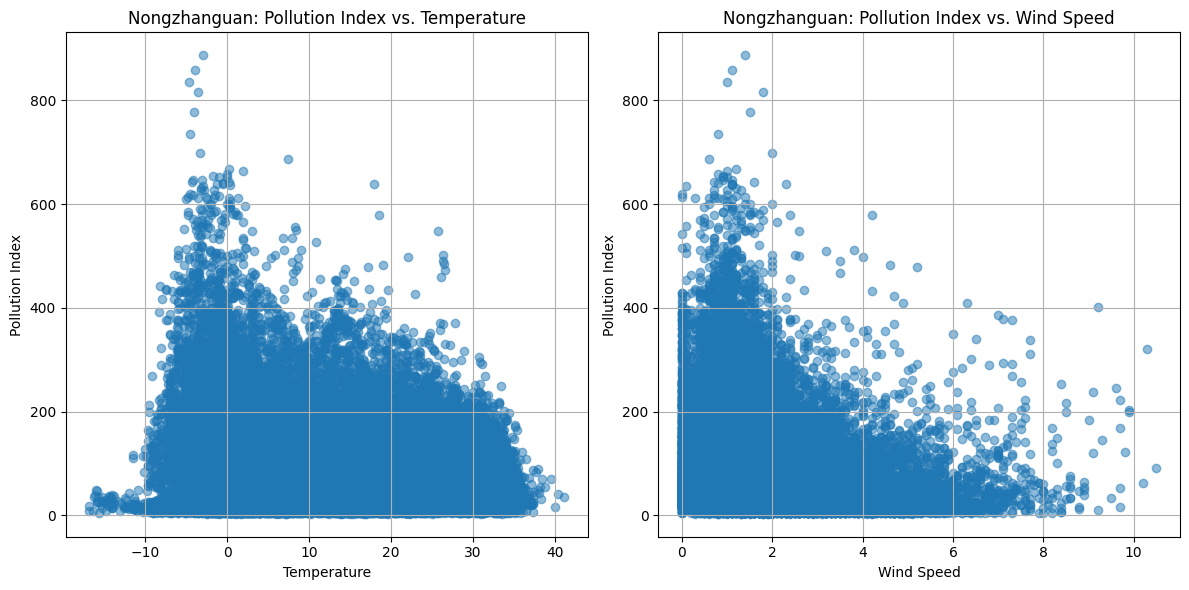

In [31]:
station_ranks = station_means.rank(ascending=False)
station_ranks['mean_rank'] = station_ranks.mean(axis=1)
station_ranks_sorted = station_ranks.sort_values(by='mean_rank')
highest_pollution_station = station_ranks_sorted.index[0]
print("Stasiun dengan tingkat polutan tertinggi secara konsisten:", highest_pollution_station)

# Filter data untuk stasiun tersebut
station_df = combined_df[combined_df['station'] == highest_pollution_station].copy()
station_df['pollution_index'] = station_df[['PM2.5', 'PM10']].mean(axis=1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(station_df['TEMP'], station_df['pollution_index'], alpha=0.5)
plt.xlabel("Temperature")
plt.ylabel("Pollution Index")
plt.title(f"{highest_pollution_station}: Pollution Index vs. Temperature")
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(station_df['WSPM'], station_df['pollution_index'], alpha=0.5)
plt.xlabel("Wind Speed")
plt.ylabel("Pollution Index")
plt.title(f"{highest_pollution_station}: Pollution Index vs. Wind Speed")
plt.grid(True)

plt.tight_layout()
plt.show()

**Insight:**
- Nongzhanguan muncul sebagai stasiun dengan tingkat polutan tertinggi secara konsisten.

### Di wilayah mana saja terdapat konsentrasi polutan (misalnya PM2.5) yang tinggi, dan bagaimana sebaran kualitas udara antar stasiun di wilayah tersebut

In [38]:
# Daftar polutan yang akan dianalisis
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

# Dictionary koordinat stasiun (latitude, longitude)
station_coords = {
    "Aotizhongxin": (39.917, 116.397),
    "Changping": (40.218, 116.231),
    "Dingling": (40.091, 116.316),
    "Dongsi": (39.935, 116.419),
    "Guanyuan": (39.941, 116.391),
    "Gucheng": (40.107, 116.261),
    "Huairou": (40.337, 116.640),
    "Nongzhanguan": (39.932, 116.360),
    "Shunyi": (40.127, 116.653),
    "Tiantan": (39.883, 116.403),
    "Wanliu": (39.979, 116.307),
    "Wanshouxigong": (39.936, 116.332)
}

# Membuat dictionary untuk menyimpan DataFrame rata-rata tiap polutan per stasiun beserta koordinat
pollutant_station_means = {}
for pollutant in pollutants:
    df_poll = combined_df.groupby('station')[[pollutant]].mean().reset_index()
    df_poll['lat'] = df_poll['station'].apply(lambda x: station_coords[x][0])
    df_poll['lon'] = df_poll['station'].apply(lambda x: station_coords[x][1])
    pollutant_station_means[pollutant] = df_poll

# Warna marker untuk tiap polutan
colors = {
    'PM2.5': 'red',
    'PM10': 'orange',
    'SO2': 'purple',
    'NO2': 'darkred',
    'CO': 'black',
    'O3': 'green'
}

# Faktor skala untuk mengatur ukuran marker (agar perbedaan nilai tampak jelas)
scaling = {
    'PM2.5': 0.1,
    'PM10': 0.05,
    'SO2': 1,
    'NO2': 1,
    'CO': 0.005,
    'O3': 1
}

# Membuat peta dasar dengan tampilan OpenStreetMap
m = folium.Map(location=[39.9, 116.4], zoom_start=10, tiles="OpenStreetMap")

# Menambahkan plugin advanced untuk pengalaman UI/UX yang lebih baik
Fullscreen().add_to(m)
MeasureControl().add_to(m)
MiniMap().add_to(m)

# Untuk setiap polutan, tambahkan dua layer: marker dan heatmap
for pollutant in pollutants:
    df_poll = pollutant_station_means[pollutant]
    
    # 1. Layer Marker: Menampilkan CircleMarker dengan popup yang menampilkan nilai numerik
    marker_fg = folium.FeatureGroup(name=f"{pollutant} - Marker", show=False)
    for idx, row in df_poll.iterrows():
        radius = 5 + row[pollutant] * scaling[pollutant]  # Ukuran marker disesuaikan dengan nilai polutan
        popup_text = f"<b>Stasiun:</b> {row['station']}<br><b>{pollutant}:</b> {row[pollutant]:.1f}"
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=radius,
            popup=popup_text,
            color=colors[pollutant],
            fill=True,
            fill_color=colors[pollutant],
            fill_opacity=0.7
        ).add_to(marker_fg)
    marker_fg.add_to(m)
    
    # 2. Layer Heatmap: Menampilkan intensitas polutan secara spasial
    # Data heatmap berupa [lat, lon, weight]
    heat_data = df_poll[['lat', 'lon', pollutant]].values.tolist()
    heat_fg = folium.FeatureGroup(name=f"{pollutant} - Heatmap", show=True)
    HeatMap(
        heat_data,
        min_opacity=0.4,
        radius=25,
        blur=15,
        max_zoom=10
    ).add_to(heat_fg)
    heat_fg.add_to(m)

# Menambahkan kontrol layer untuk memilih tampilan yang diinginkan
folium.LayerControl(collapsed=False).add_to(m)
m

**Insight:**
- Heatmap menunjukkan secara jelas blok atau area dengan intensitas tinggi untuk setiap polutan. Misalnya, untuk PM2.5, daerah yang ditandai dengan warna yang lebih pekat mengindikasikan konsentrasi yang tinggi. Ini memudahkan identifikasi hotspot yang berisiko tinggi terhadap dampak kesehatan.
- Dengan peta ini, pengambil keputusan dapat dengan mudah mengidentifikasi area mana yang harus menjadi prioritas pengendalian polusi. Misalnya, area dengan hotspot intens pada heatmap PM2.5 atau PM10 bisa menjadi target utama untuk kebijakan pengurangan emisi atau intervensi kesehatan masyarakat.

# Conclusion


- Terdapat lonjakan signifikan pada CO di 2017, yang kemungkinan terkait dengan peningkatan aktivitas pembakaran.
- Tren polutan sangat bervariasi antar stasiun, yang menandakan peran penting faktor lokal dalam menentukan kualitas udara.
- PM10 cenderung memiliki nilai rata-rata yang lebih tinggi dibandingkan PM2.5, namun peningkatan PM2.5 di beberapa stasiun (misalnya, Wanshouxigong) menjadi perhatian serius.
- Faktor lingkungan seperti kecepatan angin memiliki korelasi yang signifikan dengan penurunan konsentrasi beberapa polutan, meskipun interaksinya kompleks dan non-linear.
- Visualisasi spasial melalui heatmap dan peta interaktif memberikan pandangan yang jelas tentang distribusi polutan, memungkinkan identifikasi hotspot dan mendukung pengambilan keputusan berbasis wilayah.